# ELO Rating estimation

In [1]:
import json

with open("../rankings.json", "r") as file:
    data = json.load(file)
;

''

<Axes: ylabel='Density'>

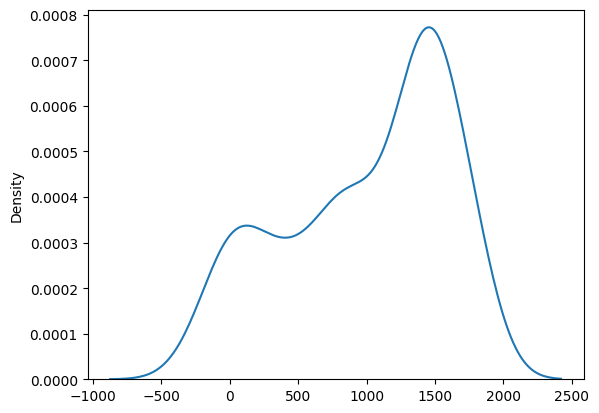

In [2]:
import seaborn as sns

# data contains two dictionaries:
# - data['results'] is a symmetrical matrix containing all the match outcomes between two players
# - data['elo'] contains the estimated elo ratings from the results computed with a simple OLS regression

sns.kdeplot(data=data['elo'])

## Estimating ELO with an OLS regression

<Axes: ylabel='Density'>

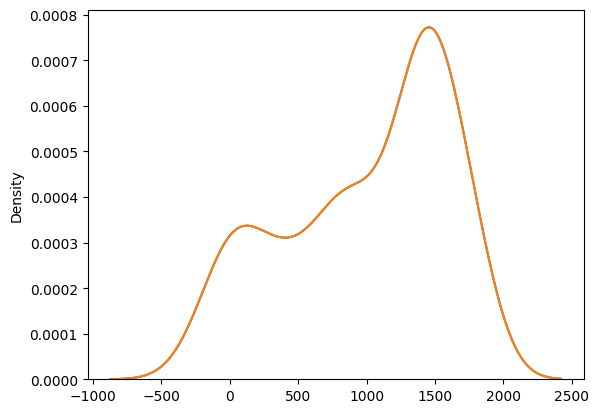

In [3]:
import numpy as np
from sklearn.linear_model import LinearRegression


def match_two_hot(i1: int, i2: int, n: int) -> np.ndarray:
    x = np.zeros(n)
    x[i1] = 1
    x[i2] = -1
    return x

def score_from_results(results): # Includes a Jeffreys Prior
    return (results[0] - results[2]) / (sum(results) + 1)

# Data should be a symmetric 2d dictionary
#
def compute_elo(data, sk=True):
    players = list(data.keys())
    player_id = {
        players[i]: i
        for i in range(len(players))
    }

    matches = [
        (player1, player2)
        for player1 in players
        for player2 in data[player1].keys()
        if player1 < player2
    ]

    X = np.array([
        match_two_hot(player_id[player1], player_id[player2], len(players))
        for player1, player2 in matches
    ] + [
        [1] * len(players)
    ])
    y = np.concatenate([
        -(400 / np.log(10)) * np.log(1 / np.clip(np.array([
            (score_from_results(data[player1][player2]) + 1) / 2
            for player1, player2 in matches
        ]), 1e-10, 1-1e-10) - 1),
        [1000 * len(players)] # We set the average elo to 1000
    ])
    w = np.concatenate([
        [sum(data[player1][player2]) for player1, player2 in matches],
        [1]
    ])
    # We solve XR=y, with R the elo ratings of the players
    reg = LinearRegression(fit_intercept=False).fit(X, y, sample_weight=w)
    elo = reg.coef_
    return dict(sorted({
        player: elo[i]
        for i, player in enumerate(players)
    }.items()))

elos = compute_elo(data['results'])
# elos should be the same as data['elo']
sns.kdeplot(data=data['elo'])
sns.kdeplot(data=elos)

In [4]:
def make_range(config):
    return range(config['start'], config['end'], config['step'])

# We group players coming from the same model run together

evr = {
    'chess_2024-04-28:21h03': {
        'start': 1,
        'end': 100,
        'step': 2,
        'label': 'fine-tuned 8 layers',
    },
    'chess_2024-04-06:22h14': {
        'start': 1,
        'end': 20,
        'step': 2,
        'label': 'fine-tuned 6 layers',
    },
    'chess_2024-03-25:18h42': {
        'start': 9,
        'end': 100,
        'step': 10,
        'label': 'base 5 layers',
    },
    'chess_2024-04-18:17h03': {
        'start': 4,
        'end': 100,
        'step': 5,
        'label': 'AlphaZero 5 layers',
    },
    'chess_2024-05-08:14h24': {
        'start': 1,
        'end': 100,
        'step': 2,
        'label': 'sparse 5 layers',
    },
    'chess_2024-05-10:15h27': {
        'start': 1,
        'end': 100,
        'step': 2,
        'label': 'dense 5 layers',
    },
    'gardner_chess_2024-04-04:17h15': {
        'start': 9,
        'end': 100,
        'step': 10,
        'label': 'gardner',
    },
}
for model, config in evr.items():
    evr[model]['elo_ols'] = [
        elos[f"{model}/{it:03}"]
        for it in make_range(config)
    ]

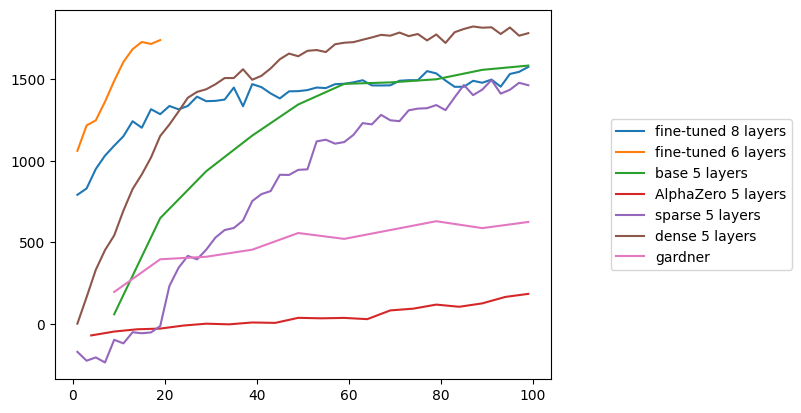

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for model, m_data in evr.items():
    ax.plot(make_range(m_data), m_data['elo_ols'], label=m_data['label'])
ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

### Manual Linear Regression

In [6]:
players = list(data['results'].keys())
players[:5]

['chess_2024-03-25:18h42/089',
 'chess_2024-03-25:18h42/099',
 'chess_2024-03-25:18h42/079',
 'chess_2024-04-06:22h14/015',
 'chess_2024-03-25:18h42/059']

In [7]:
player_id = {
    players[i]: i
    for i in range(len(players))
}

In [8]:
matches = [
    (player1, player2)
    for player1 in players
    for player2 in data['results'][player1].keys()
    if player1 < player2
]
matches[:5]

[('chess_2024-03-25:18h42/089', 'chess_2024-03-25:18h42/099'),
 ('chess_2024-03-25:18h42/089', 'chess_2024-04-06:22h14/013'),
 ('chess_2024-03-25:18h42/089', 'chess_2024-04-06:22h14/007'),
 ('chess_2024-03-25:18h42/089', 'chess_2024-04-06:22h14/009'),
 ('chess_2024-03-25:18h42/089', 'chess_2024-04-06:22h14/003')]

In [9]:
X = np.array([
    match_two_hot(player_id[player1], player_id[player2], len(players))
    for player1, player2 in matches
] + [
    [1] * len(players)
])
r_bar = np.array([
    score_from_results(data['results'][player1][player2])
    for player1, player2 in matches
])
p_bar = (r_bar + 1) / 2
y = np.concatenate([
    -(400 / np.log(10)) * np.log(1 / p_bar - 1),
    [1000 * len(players)] # We set the average elo to 1000
])
w = np.concatenate([
    [sum(data['results'][player1][player2]) for player1, player2 in matches],
    [1]
])

In [10]:
X.shape, X[:5]

((1487, 238),
 array([[ 1., -1.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.]]))

In [11]:
y.shape, y[:5]

((1487,),
 array([  22.81540039, -172.35042671,  172.35042671,   81.18536218,
         235.53269024]))

In [12]:
w.shape, w[-10:]

((1487,), array([180, 120, 120, 120, 120, 120, 120,  60,  60,   1]))

In [13]:
reg = LinearRegression(fit_intercept=False).fit(X, y, sample_weight=w)
elos_manual = dict(sorted({
    player: reg.coef_[i]
    for i, player in enumerate(players)
}.items()))
elos_manual['chess_2024-04-28:21h03/099']

def check(dic1, dic2):
    if set(dic1.keys()) != set(dic2.keys()):
        return False
    for key in dic1.keys():
        if dic1[key] != dic2[key]:
            print(key,  dic1[key], dic2[key])
            return False
    return True
check(elos, elos_manual)

True

In [14]:
sum(reg.coef_) / len(players)

999.999999999999

## Estimating ELO and Confidence Intervals with an WLS regression

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy import stats
from statsmodels.iolib.table import SimpleTable, default_txt_fmt

np.random.seed(1024)

In [16]:
# We compute the variance linked to the normal approximation to the rating differences, following Eq~15
# w contains the number of games for each match, with an extra 1 at the end

var = (400 / np.log(10)) ** 2 / (w[:-1] * p_bar * (1-p_bar))
var[96:99], w[96:99], p_bar[96:99]

(array([2160.49754561, 2067.41894381, 2056.6274713 ]),
 array([60, 60, 60]),
 array([0.63114754, 0.58196721, 0.57377049]))

In [17]:
# We need to set a low variance > 0 for the last equation, whose role is only to set the mean rating, which can be chosen arbitrarily
var = np.concatenate([var,[1e-7]])

In [18]:
var.shape

(1487,)

In [19]:
mod_wls = sm.WLS(y, X, weights=1.0 / var)
res_wls = mod_wls.fit()
print(res_wls.summary())

                                 WLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            WLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.037e+15
Date:                Tue, 21 May 2024   Prob (F-statistic):                        0.00
Time:                        15:42:27   Log-Likelihood:                         -8002.3
No. Observations:                1487   AIC:                                  1.648e+04
Df Residuals:                    1249   BIC:                                  1.774e+04
Df Model:                         238                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [20]:
res_wls.bse[player_id['gardner_chess_2024-04-22:18h50/009']]

32.0016014941316

In [21]:
sum(res_wls.params) / len(players)

1000.0000000000003

In [22]:
elos_wls = dict(sorted({
    player: res_wls.params[i]
    for i, player in enumerate(players)
}.items()))
# The standard deviations derived from the WLS
sds_wls = dict(sorted({
    player: res_wls.bse[i]
    for i, player in enumerate(players)
}.items()))
elos_wls['chess_2024-04-28:21h03/099'], sds_wls['chess_2024-04-28:21h03/099']

(1629.2953370478388, 17.028119015597554)

In [23]:
from scipy.stats import norm

ic = 0.95
ic = 0.99999943
norm.ppf(1-(1-ic)/2)

5.001113980125975

In [24]:
ic = 0.95
sigma = norm.ppf(1-(1-ic)/2)
sigma = 2
for model, config in evr.items():
    evr[model]['elo_wls'] = [
        elos_wls[f"{model}/{it:03}"]
        for it in make_range(config)
    ]
    evr[model]['sd_wls'] = [
        sds_wls[f"{model}/{it:03}"]
        for it in make_range(config)
    ]
    evr[model]['ci_wls'] = sigma * np.array(evr[model]['sd_wls'])

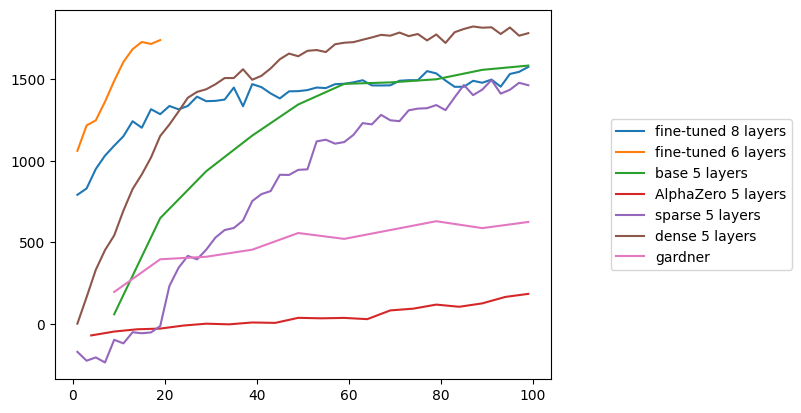

In [25]:
# OLS ELO

fig, ax = plt.subplots()
for model, m_data in evr.items():
    ax.plot(make_range(m_data), m_data['elo_ols'], label=m_data['label'])
ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

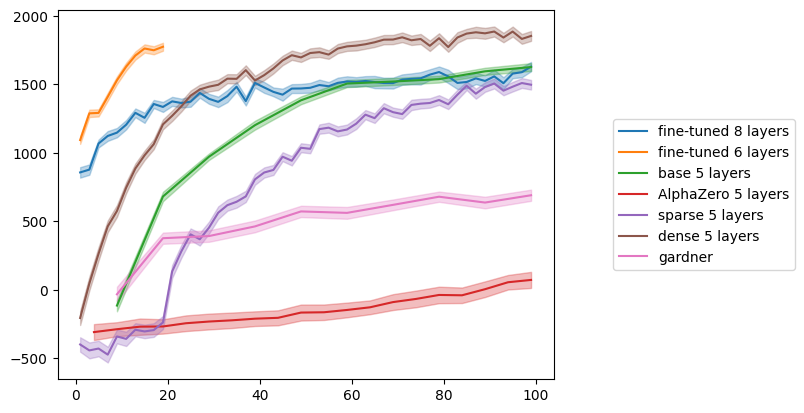

In [26]:
# WLS ELO

fig, ax = plt.subplots()
for i, (model, m_data) in enumerate(evr.items()):
    ax.plot(make_range(m_data), m_data['elo_wls'], label=m_data['label'])
    ax.fill_between(
        make_range(m_data),
        m_data['elo_wls'] - m_data['ci_wls'],
        m_data['elo_wls'] + m_data['ci_wls'],
        alpha=0.3,
        color=f"C{i}"
    )
ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

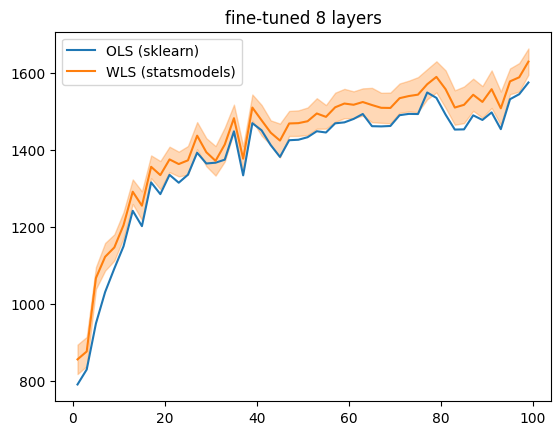

In [27]:
def compare_ols_wls(model, title):
    plt.plot(make_range(evr[model]), evr[model]['elo_ols'], label="OLS (sklearn)")
    plt.plot(make_range(evr[model]), evr[model]['elo_wls'], label="WLS (statsmodels)")
    plt.fill_between(
        make_range(evr[model]),
        evr[model]['elo_wls'] - evr[model]['ci_wls'],
        evr[model]['elo_wls'] + evr[model]['ci_wls'],
        alpha=0.3,
        color="C1"
    )
    plt.title(title)
    plt.legend()

compare_ols_wls('chess_2024-04-28:21h03', 'fine-tuned 8 layers')

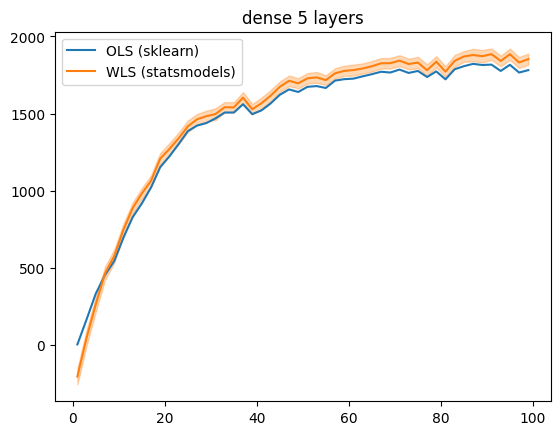

In [28]:
compare_ols_wls('chess_2024-05-10:15h27', 'dense 5 layers')

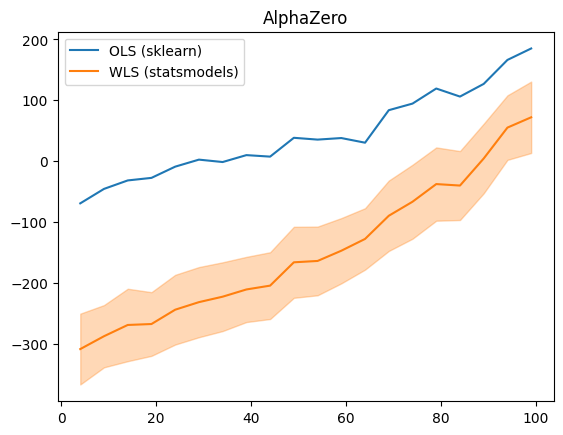

In [29]:
compare_ols_wls('chess_2024-04-18:17h03', 'AlphaZero')

In [48]:
def print_elo_approx(model, it):
    print(evr[model]['elo_wls'][it], '±', evr[model]['sd_wls'][it])
    print(f"{evr[model]['elo_wls'][it]:.0f} ± {evr[model]['sd_wls'][it]:.0f}")

# AlphaZero last ELO
print_elo_approx('chess_2024-04-18:17h03', -1)

72.05486360113429 ± 29.341706993561054
72 ± 29


In [49]:
# AlphaGateau last ELO
print_elo_approx('chess_2024-03-25:18h42', -1)

1626.007757358934 ± 14.185155449519355
1626 ± 14


In [51]:
# 5x5 training last ELO
print_elo_approx('gardner_chess_2024-04-04:17h15', -1)

690.2085936540568 ± 20.432717662219336
690 ± 20


In [53]:
# 5x5 training last ELO
print_elo_approx('chess_2024-04-06:22h14', -1)

1774.3682136845075 ± 14.562979253250921
1774 ± 15


In [54]:
from cycler import cycler

monochrome = (cycler('linestyle', ['-', '--', ':']) * cycler('marker', ['^',',', '.']))

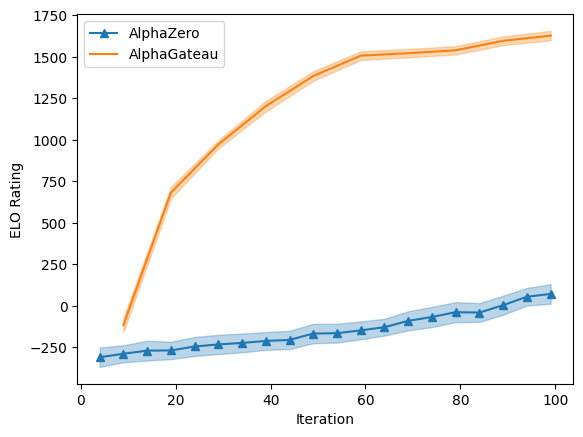

In [61]:
def clean_plot(model_names, labels):
    fig, ax = plt.subplots()
    ax.set_prop_cycle(monochrome)
    for i, (model_name, label) in enumerate(zip(model_names, labels)):
        model = None
        for m in evr.keys():
            if evr[m]['label'] == model_name:
                model = m
        m_data = evr[model]
        ax.plot(make_range(m_data), m_data['elo_wls'], label=label, color=f"C{i}")
        ax.fill_between(
            make_range(m_data),
            m_data['elo_wls'] - m_data['ci_wls'],
            m_data['elo_wls'] + m_data['ci_wls'],
            alpha=0.3,
            color=f"C{i}"
        )
    pos = ax.get_position()
    ax.set_xlabel('Iteration')
    ax.set_ylabel('ELO Rating')
    ax.legend()
    return fig
    
fig = clean_plot(['AlphaZero 5 layers', 'base 5 layers'], ['AlphaZero', 'AlphaGateau'])
fig.savefig('../figures/exp1.pdf')

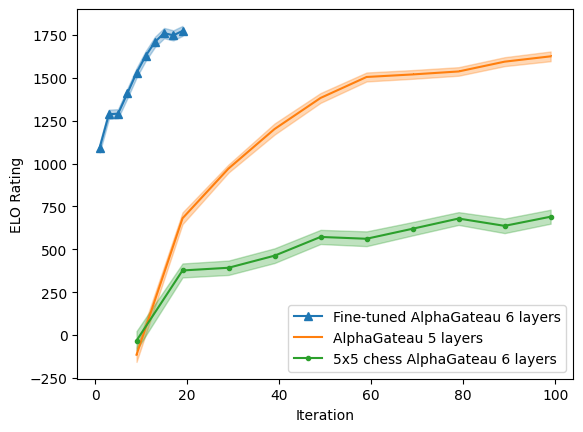

In [62]:
fig = clean_plot(['fine-tuned 6 layers', 'base 5 layers', 'gardner'], ['Fine-tuned AlphaGateau 6 layers', 'AlphaGateau 5 layers', '5x5 chess AlphaGateau 6 layers'])
fig.savefig('../figures/exp2.pdf')

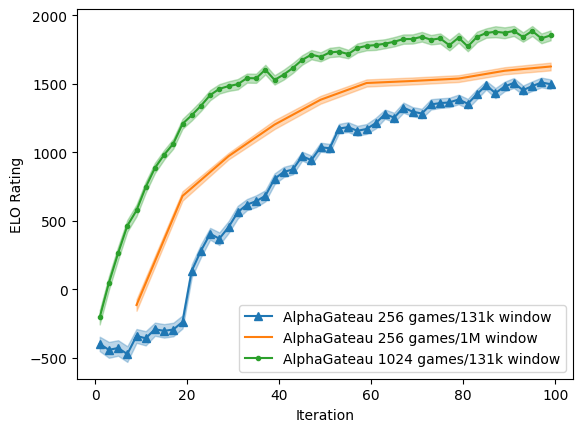

In [63]:
fig = clean_plot(['sparse 5 layers', 'base 5 layers', 'dense 5 layers'], ['AlphaGateau 256 games/131k window', 'AlphaGateau 256 games/1M window', 'AlphaGateau 1024 games/131k window'])
fig.savefig('../figures/exp3.pdf')

In [64]:
evr['chess_2024-05-10:15h27']['elo_wls']

[-205.65846818255307,
 46.103578954456054,
 262.9932030202057,
 463.300000384096,
 575.3070797464158,
 745.1262112527811,
 885.3745512204944,
 981.5790748762031,
 1063.0440757900951,
 1207.6239242903434,
 1270.247161932078,
 1339.2587234808125,
 1417.0502530885092,
 1462.8465107439704,
 1482.869224549591,
 1496.5389808353145,
 1541.2270183580695,
 1540.0129385680495,
 1603.306714285434,
 1527.9883679644975,
 1566.994831523748,
 1615.8416156757303,
 1674.0170129355806,
 1712.488429578993,
 1696.3831932350363,
 1728.4069527832794,
 1734.807557321149,
 1717.053161654776,
 1761.0571116365136,
 1776.989495371854,
 1782.3380861584094,
 1792.4651261314343,
 1806.8324724713154,
 1826.0545833176284,
 1826.868477141772,
 1843.2508853018912,
 1821.4532258309941,
 1830.8773941877491,
 1781.3146359090365,
 1836.5817587566605,
 1772.175897132362,
 1841.9103923235411,
 1870.348841093126,
 1879.8994995256983,
 1872.1683394887991,
 1885.4508774129004,
 1841.3388363468448,
 1885.1172835967031,
 1831.408

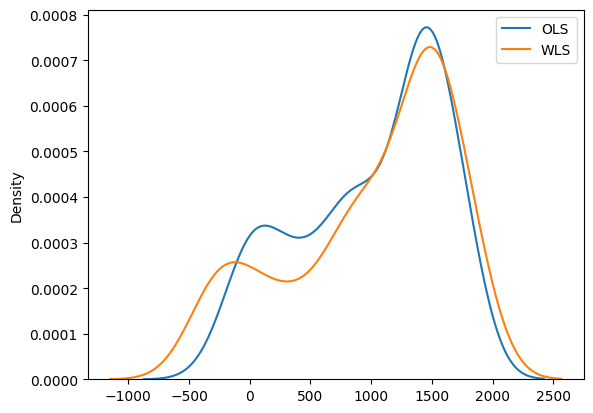

In [68]:
sns.kdeplot(data=data['elo'], label='OLS')
sns.kdeplot(data=res_wls.params, label='WLS')
plt.legend()

Text(0.5, 1.0, 'Standard Errors')

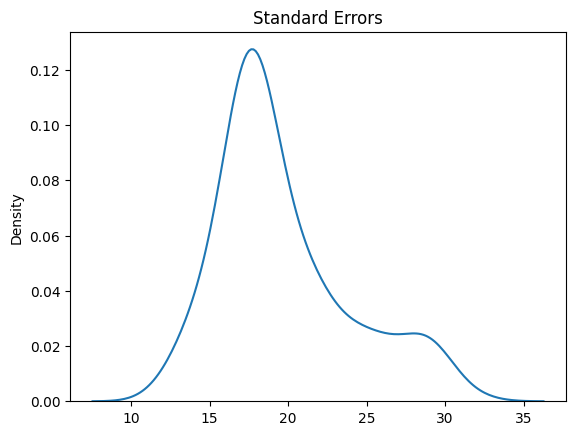

In [69]:
sns.kdeplot(data=res_wls.bse)
plt.title("Standard Errors")

In [71]:
elos_manual['chess_2024-05-10:15h27/099']

1781.6910142394127

In [72]:
for opp, res in data['results']['chess_2024-05-10:15h27/099'].items():
    print(f"{opp}[{elos_manual[opp]}] {(res[0] - res[2]) / sum(res): .3f} {sum(res)}")

chess_2024-04-28:21h03/007[1031.5719860767629]  0.883 60
chess_2024-04-06:22h14/009[1489.302791678513]  0.667 60
chess_2024-04-06:22h14/011[1605.4148751746543]  0.450 60
chess_2024-05-10:15h27/055[1666.0591623427702]  0.483 60
chess_2024-05-10:15h27/061[1726.6734351043988]  0.317 60
chess_2024-05-10:15h27/057[1713.775659844686]  0.300 60
chess_2024-05-10:15h27/063[1741.5158196967304]  0.300 60
chess_2024-05-10:15h27/069[1766.1889694613355]  0.008 120
chess_2024-05-10:15h27/079[1773.623888111821] -0.017 60
chess_2024-05-10:15h27/073[1763.5075673510169]  0.117 60
chess_2024-05-10:15h27/097[1766.2309399781593]  0.217 60
chess_2024-05-10:15h27/075[1776.488417946814]  0.100 60
chess_2024-05-10:15h27/093[1776.547083220054]  0.083 60


In [42]:
data['results']['chess_2024-05-10:15h27/099']

{'chess_2024-04-28:21h03/007': [53, 7, 0],
 'chess_2024-04-06:22h14/009': [45, 10, 5],
 'chess_2024-04-06:22h14/011': [37, 13, 10],
 'chess_2024-05-10:15h27/055': [38, 13, 9],
 'chess_2024-05-10:15h27/061': [32, 15, 13],
 'chess_2024-05-10:15h27/057': [30, 18, 12],
 'chess_2024-05-10:15h27/063': [30, 18, 12],
 'chess_2024-05-10:15h27/069': [41, 39, 40],
 'chess_2024-05-10:15h27/079': [20, 19, 21],
 'chess_2024-05-10:15h27/073': [23, 21, 16],
 'chess_2024-05-10:15h27/097': [31, 11, 18],
 'chess_2024-05-10:15h27/075': [23, 20, 17],
 'chess_2024-05-10:15h27/093': [18, 29, 13]}

In [43]:
evr['chess_2024-05-10:15h27']

{'start': 1,
 'end': 100,
 'step': 2,
 'label': 'dense 5 layers',
 'elo': [-6.577895197704663,
  165.19114537510188,
  341.01814950145325,
  459.38982720653127,
  558.7298296828075,
  692.6305728622831,
  823.6089320561292,
  919.6541811549911,
  1022.6459908609348,
  1140.5939164716856,
  1215.3227443535825,
  1294.1903690040667,
  1389.22330539516,
  1414.5799165668245,
  1431.9322785705883,
  1469.9779615782531,
  1506.2425673029056,
  1504.4906477610161,
  1564.9230232244115,
  1497.528248163638,
  1516.270262795759,
  1568.7572034745253,
  1627.4049649591357,
  1660.2348105922533,
  1643.3868730241086,
  1676.8147544831843,
  1684.2275125415222,
  1669.2867769477327,
  1716.6523929167408,
  1726.3289777676591,
  1732.2493069696459,
  1744.3839010633278,
  1758.2656949277753,
  1774.0142700051103,
  1769.2129013982412,
  1788.8884317094112,
  1766.6884976596375,
  1779.6306185611904,
  1740.2482498001723,
  1776.6448462097164,
  1725.452237256403,
  1790.6533381513382,
  1810.52361